# Initial analysis

### 1. Imports

In [108]:
import os

import dotenv
dotenv.load_dotenv()

import h5py

import numpy as np

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
# Typing Stuff
from typing import Dict
from typing import Any
from typing import Tuple
from typing import Callable

### 2. Loading the data...

In [3]:
# Notes:
#   - Don't forget to close the file.
#   - The full dataset is stored locally.

my_data = h5py.File(os.environ['MINI_DATA_DIR'], 'r')

In [ ]:
# for key in my_data.keys():
#     print('Parent Key:', key)
#     try:
#         print('\tChildren Keys:', my_data[key].keys())
#     except AttributeError:
#         pass

From the code cell above (might be commeted out for you) we can see that the simplified ("mini") dataset does not have any child keys! The bigger dataset (used in 'ref/pidFunSelNotSel.ipynb'), however, does have several child keys for some of the parent keys.

Therefore, only the most essential data is probably stored in this "mini" dataset.

Update: After further analysis of the code, the columns with suffix 'All' were made using the parameters from the bigger dataset... Like dimensionality reduction. Refer to the code below.

```python
def fillTruthVars(td):
    numNu=np.sum(td['rec.mc.nnu'])
    nnuIndex=np.cumsum(td['rec.mc.nnu'])
    nnuIndex=np.concatenate(([0],nnuIndex))
    nnuIndex[nnuIndex==numNu]=numNu-1  #If the last few entries are cosmics they
    print(nnuIndex[-10:]) #will try and access elements that don't exist
    td['nnuIndex']=nnuIndex
    td['pdgAll']=td['rec.mc.nu.pdg'][nnuIndex[0:-1]]*(td['rec.mc.nnu']>0.5) #The *(nnuVals>0) part sets all non-neutrinos (cosmics??) to zero for the pdg
    td['ccAll']=td['rec.mc.nu.iscc'][nnuIndex[0:-1]]*(td['rec.mc.nnu']>0.5)
    td['modeAll']=td['rec.mc.nu.mode'][nnuIndex[0:-1]]*(td['rec.mc.nnu']>0.5) #The *(nnuVals>0) part sets all non-neutrinos (cosmics??) to zero for the pdg
    td['trueEnu']=td['rec.mc.nu.E'][nnuIndex[0:-1]]*(td['rec.mc.nnu']>0.5)
    td['isNotNu']=td['rec.mc.nnu']<1
    td['isCC']=td['ccAll']>0
    td['isNC']=(td['rec.mc.nnu']*(1-td['isCC'])>0)
    td['isNuMu']=(td['pdgAll']==14)
    td['isNuMuCC']=(td['pdgAll']==14)*td['isCC']
    td['isANuMuCC']=(td['pdgAll']==-14)*td['isCC']
    td['isNuECC']=(td['pdgAll']==12)*td['isCC']
    td['isANuECC']=(td['pdgAll']==-12)*td['isCC']
```

Furthermore, the data is focusing on $\nu_\mu$ (or hadronic events) hence stuff about $\nu_\text{e}$ or $\nu_\tau$ is mostly ignored in this dataset.

#### 2.1 Information about all the keys in the file above...

- `'3flavourveto'` :
- `'cosBeamFirst'` : cos(Angle off beam axis) between [0, 1]

**Reduced parameters**

- `'pdgAll'`  : Relevant PDGIDs (refer to [this](https://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf)) could be one of three: 0, $\pm$ 12 ($\nu_\text{e}$ or $\bar{\nu}_\text{e}$), or $\pm$ 14 ($\nu_\mu$ or $\bar{\nu}_\mu$).
- `'ccAll'`   : Flag for all CC events (uint16) (Note: Maybe convert to boolean?)
- `'modeAll'` : Interaction mode (e.g. 0 means a QE interaction)

**Flags** (bool)

- `'isANuECC'`    : $\bar{\nu}_\text{e}$ CC events
- `'isANuMuCC'`   : $\bar{\nu}_\mu$ CC events
- `'isCC'`        : Charged current events
- `'isNC'`        : Neutral current events
- `'isNotNu'`     : Non-$\nu$ events ??
- `'isNuECC'`     : Elastic CC events
- `'isNuMu'`      : Muon-neutrino events
- `'isNuMuCC'`    : Muon-neutrino CC events

**Cuts** (bool)

- `'numu2020pid'`        : Muon-neutrino CVN PID cut
- `'numuBasicQuality'`   : Basic quality cut
- `'numuQuality'`        : Quality cut
- `'numucontain'`        : Muon-neutrino containment cut
- `'numucosrej'`         : Cosmic rejection cut
- `'numufull'`           : Events that pass all the cuts
- `'numunotpid'`         : Events that pass all cuts except CVN PID

**Momentum** (float32)

- `'pmu'`  : Muon momentum $p$ [GeV]
- `'pt'`   : Transverse momentum $p_t$ [GeV]
- `'ptp'`  : $p_t / p$

**Reconstructed stuff**

- `'rec.energy.numu.E'`              : $\nu_\mu$ energy [GeV] (float32)
- `'rec.energy.numu.calccE'`         : Calorimetric CC energy [GeV] (float32) ??
- `'rec.energy.numu.lstmmuon'`       : LSTM Predicted $\nu_\mu$ energy [GeV] (float32)
- `'rec.energy.numu.lstmnu'`         : LSTM Predicted $\nu$ energy [GeV] (float32) (Note: Same as above...)
- `'rec.energy.numu.hadcalE'`        : (float32) ??
- `'rec.energy.numu.hadclust.calE'`  : Hadronic calorimetric energy [GeV] (float32)
- `'rec.energy.numu.hadtrkE'`        : Hadronic track energy [GeV] (float32) ??
- `'rec.energy.numu.regcvnhadE'`     : Regression CVN hadronic energy [GeV] (float32)
- `'rec.energy.numu.hadclust.nhit'`  : Number of hadronic hits (uint32)
- `'rec.mc.nnu'`                     : Flag for $\mu$ events according to MC simulation (int16)
- `'rec.sel.contain.cosbakcell'`     : (int32) ??

**Pre-selection CVN**: Scores used to predict the type of particle interaction (float32)

- `'rec.sel.cvnloosepreselptp.cosmicid'` - Cosmogenic events
- `'rec.sel.cvnloosepreselptp.ncid'`     - NC events
- `'rec.sel.cvnloosepreselptp.nueid'`    - $\nu_\text{e}$ events
- `'rec.sel.cvnloosepreselptp.numuid'`   - $\nu_\mu$ events
- `'rec.sel.cvnloosepreselptp.nutauid'`  - $\nu_\tau$ events

**More selection stuff** (float32)

- `'rec.sel.remid.pid'`                  : 
- `'rec.sel.scann.scpid'`                : 
- `'rec.slc.ncontplanes'`                : Plane number where particle stopped ??
- `'rec.slc.nhit'`                       : 

**Reconstructed track data** (??)

- `'rec.trk.cosmic.ntracks'` :
- `'rec.trk.kalman.ntracks'` :
- `'recoq2'`                 : Reconstructed $Q^2$ [GeV^2] (float32)
- `'recow'`                  : Reconstructed hadronic invariant mass (float32) (Note: Half of these were null)
- `'trueEnu'`                : True energy of the $\nu$ (float32)

### 3. Getting Started

First, I want to see what the data looks like, and the most convinent method of doing this this using the Pandas library. I will first load the first 1,000 or so records from the H5 file to a Python dictionary and then load this into a Pandas `DataFrame`.

Update: In later version of this code, I decided that I could use more data so I have pulled the first 1,000,0000 records!

In [4]:
# Number of records I want to pull from the H5 file
n_records = 1_000_000

In [5]:
data: Dict[str, Any] = {
    key:my_data[key][:n_records] for key in my_data.keys()
}

df = pd.DataFrame(data)

del data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 48 columns):
 #   Column                              Non-Null Count    Dtype  
---  ------                              --------------    -----  
 0   3flavourveto                        1000000 non-null  bool   
 1   ccAll                               1000000 non-null  uint16 
 2   cosBeamFirst                        1000000 non-null  float32
 3   isANuECC                            1000000 non-null  bool   
 4   isANuMuCC                           1000000 non-null  bool   
 5   isCC                                1000000 non-null  bool   
 6   isNC                                1000000 non-null  bool   
 7   isNotNu                             1000000 non-null  bool   
 8   isNuECC                             1000000 non-null  bool   
 9   isNuMu                              1000000 non-null  bool   
 10  isNuMuCC                            1000000 non-null  bool   
 11  modeAll     

In [7]:
# I wrote the stuff below to seperate HTML documents...
# - `df.to_html()`
# - `df.corr().style.background_gradient(cmap='coolwarm')`
# - `df.describe().to_html()`

Out of all the columns, we can see that `'recow'` (reconstructed hadronic invariant mass) is the only one that contains null values! Why this happens we can explore later in the notebook...

For now, the NaN values will be replaced with 0.

In [147]:
df['recow'] = df['recow'].fillna(value=0)

In [166]:
EVENT_INFO_STR = """\
== Event Info =============================================
|
|   Flavour                     {}
|   Interaction                 {}
|
|   Nu Energy                   {:0.3f} GeV
|   Cos(Theta)                  {:0.3f} deg
|
|   Reconstructed:
|
|       Nu Energy               {:0.3f} GeV
|       Q-squared               {:0.3f} GeV
|       Hadronic Inv. Mass      {:0.3f} GeV
|       # of Hadronic Hits      {}
|
|   LSTM Predictions:
|
|       Nu Energy               {:0.3f} GeV
|       Muon Energy             {:0.3f} GeV
|
|   Regression CVN Prediction:
|
|       Hadronic Energy         {:0.3f} GeV
|
|   Cuts:
|
|       Quality                 {}
|       Containment             {}
|       Pre-selection CVN       ------>  Likely {} ?
|       Cosmic Rejection        {}
|       Hadronic (NuMu) CNV     {}
| 
===========================================================
"""


def print_event_info(event: pd.Series) -> None:
    """\
    Prints some of the important details of the event.

    Args:
    -----
    event: pd.Series
        Event data. This is simply a row/record of the loaded `pd.DataFrame`.
    """
    flavour = 'Unknown'
    current = ''
    
    if event['isCC']:
        current = 'CC'

    if event['isNC']:
        current = 'NC'
    
    anti_prefix = 'Anti-' if event['pdgAll'] < 0 else ''

    if event['isNotNu']:
        flavour = 'N/A'
    else:
        if abs(event['pdgAll']) == 12:
            flavour = 'NuE'
        elif abs(event['pdgAll']) == 14:
            flavour = 'NuMu'
        elif abs(event['pdgAll']) == 16:
            flavour = 'NuTau'

    mode_ref_table: Dict[int, str] = {
        -1 : 'Unknown',      
        0  : 'QE',
        1  : 'Res',
        2  : 'DIS',
        3  : 'Coh',
        4  : 'CohElastic',
        5  : 'ElectronScattering',
        6  : 'IMDAnnihilation',
        7  : 'InverseBetaDecay',
        8  : 'GlashowResonance',
        9  : 'AMNuGamma',
        10 : 'MEC',
        11 : 'Diffractive',
        12 : 'EM',
        13 : 'WeakMix'
    }

    pre_sel_cvn_scores: Dict[str, float] = {
        'Cosmic': event['rec.sel.cvnloosepreselptp.cosmicid'],
        'NC'    : event['rec.sel.cvnloosepreselptp.ncid'],
        'NuE'   : event['rec.sel.cvnloosepreselptp.nueid'],
        'NuMu'  : event['rec.sel.cvnloosepreselptp.numuid'],
        # 'NuTau' : event['rec.sel.cvnloosepreselptp.nutauid'],
        # Tau events are ignored due to weird scores...
    }

    high_pre_sel_cvn_score_index = np.argmax(list(pre_sel_cvn_scores.values()))

    quality_cuts = event['numuBasicQuality'] and event['numuQuality']

    print(
        EVENT_INFO_STR.format(
            #
            anti_prefix + flavour,
            mode_ref_table[event['modeAll']] + ' ' + current,
            
            # True values
            event['trueEnu'],
            event['cosBeamFirst'],

            # Reconstructed
            event['rec.energy.numu.E'],
            event['recoq2'],
            event['recow'],
            event['rec.energy.numu.hadclust.nhit'],

            # Predictions
            event['rec.energy.numu.lstmnu'],
            event['rec.energy.numu.lstmmuon'],
            event['rec.energy.numu.regcvnhadE'],

            # Cuts
            'Passed' if quality_cuts else 'Failed',
            'Passed' if event['numucontain'] else 'Failed',
            list(pre_sel_cvn_scores)[high_pre_sel_cvn_score_index],
            'Passed' if event['numucosrej'] else 'Failed',
            'Passed' if event['numu2020pid'] else 'Failed'
        )
    )


In [161]:
print_event_info(event=df.iloc[np.random.randint(0, n_records)])

== Event Info =============================================
|
|   Flavour                     Anti-NuMu
|   Interaction                 DIS CC
|
|   Nu Energy                   38.370 GeV
|   Cos(Theta)                  0.642 deg
|
|   Reconstructed:
|
|       Nu Energy               3.128 GeV
|       Q-squared               1.887 GeV
|       Hadronic Inv. Mass      1.850 GeV
|       # of Hadronic Hits      124
|
|   LSTM Predictions:
|
|       Nu Energy               3.181 GeV
|       Muon Energy             0.820 GeV
|
|   Regression CVN Prediction:
|
|       Hadronic Energy         1.653 GeV
|
|   Cuts:
|
|       Quality                 Passed
|       Containment             Failed
|       Pre-selection CVN       ------>  Likely NuMu ?
|       Cosmic Rejection        Passed
|       Hadronic (NuMu) CNV     Passed
| 




### 4. Playing with the data

Below, I have plotted some of the data from the mini "mini" database...

In [167]:
def draw_plot_info(ax) -> Callable[[pd.Series, Any, str], None]:
    """\
    Draws simple stats beside the histogram axes - similar to ROOT.
    
    Args:
    -----
    ax: mpl.Axes
        Axes object of the plot (e.g. initialised via `plt.subplots`).

    Returns:
    --------
    Callable[[pd.Series, str], None]
        Function which updates the plot axes.
    """
    n = 0  # Updates the offset...
           # Plotting too many not reccomended!

    text_str = "{0}:\nEntries  {1}\nMean     {2:0.3f}\nStd Dev {3:0.3f}"

    def update(data: pd.Series, 
               bar_container, 
               label: str) -> None:
        """\
        Function updates the plot axes according to given data.

        Args:
        -----
        data: pd.Series
            Data plotted on the histogram. This is simply the column of the `pd.DataFrame`.

        bar_container: mpl.BarContainer
            The last thing that is retured by `plt.hist` or `ax.hist`.

        label: str
            Label of the histogram - will be drawn like a plot legend.
            
        """
        nonlocal n

        patch = bar_container.patches[0]

        bbox = dict(
            boxstyle='round', 
            facecolor=patch.get_facecolor(),
            alpha=patch.get_alpha()
        )

        ax.text(
            1.05, 1.0 - 0.25 * n,
            text_str.format(
                label,
                len(data),
                data.mean(), 
                data.std()
            ),
            transform=ax.transAxes, 
            verticalalignment='top', 
            bbox=bbox
        )

        n += 1
    
    return update

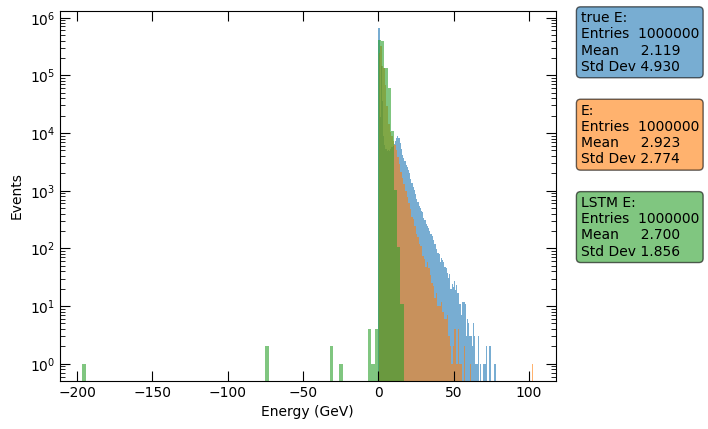

In [155]:
fig, ax = plt.subplots()

plot_info = draw_plot_info(ax)

# bins_conf = np.linspace(0, 1, 100 + 1)
bins_conf = 100

*_, bc = ax.hist(df['trueEnu'], bins=bins_conf, alpha=0.6)
plot_info(df['trueEnu'], bc, 'true E')

*_, bc = ax.hist(df['rec.energy.numu.E'], bins=bins_conf, alpha=0.6)
plot_info(df['rec.energy.numu.E'], bc, 'E')

*_, bc = ax.hist(df['rec.energy.numu.lstmnu'], bins=bins_conf, alpha=0.6)
plot_info(df['rec.energy.numu.lstmnu'], bc, 'LSTM E')

ax.tick_params(axis='both', direction='in', top=True, right=True, size=7)
ax.tick_params(axis='both', which='minor', direction='in', right=True, size=3.5)

ax.set_yscale('log')

ax.set_xlabel(r'Energy (GeV)')
ax.set_ylabel(r'Events');


Why is there negative energy? Could this refer to anti-particles?

In [157]:
df[df['rec.energy.numu.lstmnu'] <= 0]['pdgAll']

13154     14
230792     0
377197     0
378968     0
382709     0
385125     0
430931     0
431624     0
432625     0
499302     0
577437    14
600676     0
600994     0
634284     0
771017     0
800832     0
812045     0
875842     0
876010     0
876124     0
Name: pdgAll, dtype: int16

All their PDGIDs seem to be positive (i.e. they are all normal particles), so it could be that the LSTM is predicting stuff weirdly? 

For now, let us reject the energy data which falls below 0.

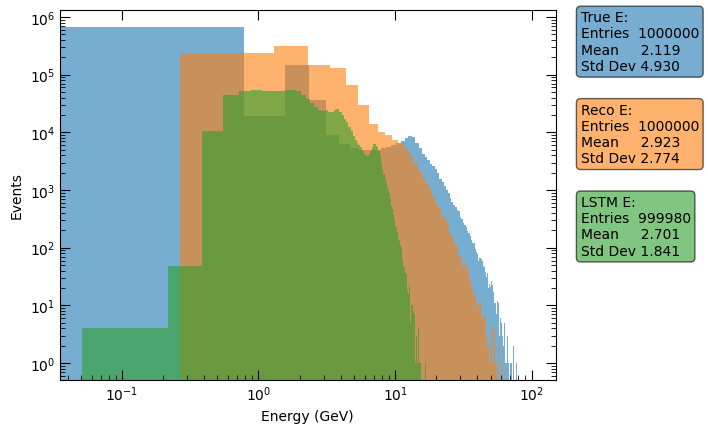

In [165]:
fig, ax = plt.subplots()

plot_info = draw_plot_info(ax)

# bins_conf = np.linspace(0, 1, 100 + 1)
bins_conf = 100

*_, bc = ax.hist(df['trueEnu'], bins=bins_conf, alpha=0.6)
plot_info(df['trueEnu'], bc, 'True E')

*_, bc = ax.hist(df['rec.energy.numu.E'], bins=bins_conf, alpha=0.6)
plot_info(df['rec.energy.numu.E'], bc, 'Reco E')

filtered_lstm_predictions = df['rec.energy.numu.lstmnu'][df['rec.energy.numu.lstmnu'] >= 0]

*_, bc = ax.hist(filtered_lstm_predictions, bins=bins_conf, alpha=0.6)
plot_info(filtered_lstm_predictions, bc, 'LSTM E')

ax.tick_params(axis='both', direction='in', top=True, right=True, size=7)
ax.tick_params(axis='both', which='minor', direction='in', right=True, size=3.5)

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel(r'Energy (GeV)')
ax.set_ylabel(r'Events');


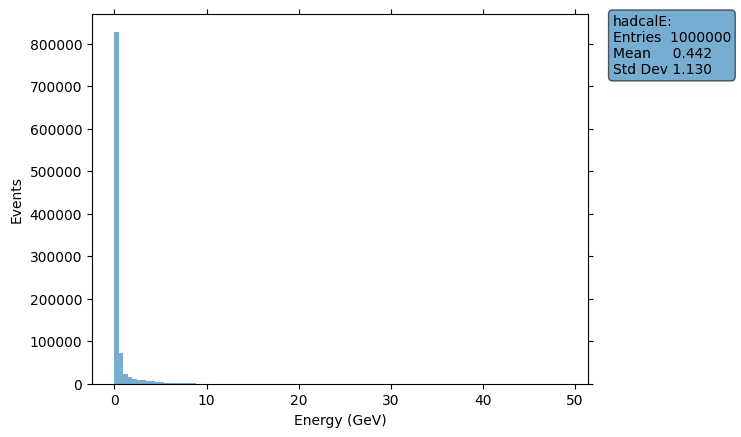

In [14]:
fig, ax = plt.subplots()

plot_info = draw_plot_info(ax)

*_, bc = ax.hist(df['rec.energy.numu.hadcalE'], bins=bins_conf, alpha=0.6)
plot_info(df['rec.energy.numu.hadcalE'], bc, 'hadcalE')

ax.tick_params(top=True, right=True)

ax.set_xlabel(r'Energy (GeV)')
ax.set_ylabel(r'Events');


In [ ]:
my_data.close()